In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
import mmcv
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(mmcv.__version__)
print(get_compiling_cuda_version())
print(get_compiler_version())

# Check mmocr installation
import mmocr
print(mmocr.__version__)

%cd /home/cvk/mmocr/
!ls

1.7.0+cu110 True
2.18.0
1.3.17
11.0
GCC 7.3
0.3.0
/home/cvk/mmocr
 annot				 node_modules
 annotorious-openseadragon	 output_hocr.hocr
 bounding_boxes.csv		 output_hocr.txt
 box.png			 outputs
 CITATION.cff			 package-lock.json
 configs			 README.md
 data				 README_zh-CN.md
 default10000.png		 requirements
 demo				 requirements.txt
 docker				 resources
 docs				 result100.png
 docs_zh_CN			 result100.txt
 east_coco.ipynb		 result1.csv
 edges-50-150.jpg		 result.csv
 example1.pdf			 result.png
 example2.pdf			 setup.cfg
 example3.pdf			 setup.py
 example4.pdf			 TableOCR.ipynb
 example5.pdf			 TableOCR-Kmeans.ipynb
 example6.pdf			'TableWithGridLayoutOCR 1.01.ipynb'
 example7.pdf			 temp.png
 example.pdf			 test10.csv
 Final_round_mmocr-Copy1.ipynb	 test1.csv
 Final_round_mmocr-Copy2.ipynb	 test5.csv
 Final_round_mmocr-Copy3.ipynb	 test6.csv
 Final_round_mmocr-Copy4.ipynb	 test7.csv
 Final_round_mmocr.ipynb	 test8.csv
 frozen_east_text_detection.pb	 test9.csv
 houghlines3.jpg		 test.

In [2]:
from mmocr.utils.ocr import MMOCR
import pytesseract
import cv2

img = 'demo/img/demo2.png'


mmocr = MMOCR(det='PS_CTW',kie = 'SDMGR')
#mmocr.readtext(img, print_result = False, output='demo/out004.png')
a = mmocr.readtext(img, details=True)

results = []
image = cv2.imread(img)

for element in a[0]['result']:
    x = 0
    y = 0
    xs = []
    ys = []
    for idx, i in enumerate(element['box']):
        if idx % 2 == 0:
            xs.append(i)
            x += i
        else:
            ys.append(i)
            y += i
            
    x = round(x / (len(element['box'])/2))
    y = round(y / (len(element['box'])/2))
    
    crop = image[min(ys):max(ys), min(xs):max(xs)]
    config = ("-l eng --oem 3 --psm 13")
    text = pytesseract.image_to_string(crop, config=config)

    results.append({
        'x': x,
        'y': y,
        'text': text.replace('|',''),
        'xmin':min(xs),
        'xmax':max(xs),
        'ymin':min(ys),
        'ymax':max(ys),
        
    })



load checkpoint from http path: https://download.openmmlab.com/mmocr/textdet/psenet/psenet_r50_fpnf_600e_ctw1500_20210401-216fed50.pth


/home/cvk/mmocr/mmocr/apis/inference.py:48: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


load checkpoint from http path: https://download.openmmlab.com/mmocr/textrecog/seg/seg_r31_1by16_fpnocr_academic-72235b11.pth
load checkpoint from http path: https://download.openmmlab.com/mmocr/kie/sdmgr/sdmgr_unet16_60e_wildreceipt_20210520-7489e6de.pth


/home/cvk/.local/lib/python3.8/site-packages/mmdet/datasets/utils.py:65: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
/home/cvk/mmocr/mmocr/datasets/kie_dataset.py:43: UserWarning: KIEDataset is only initialized as a downstream demo task of text detection and recognition without an annotation file.
  warnings.warn(
/home/cvk/.local/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
/home/cvk/mmocr/mmocr/datasets/pipelines/box_utils.py:46: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, us

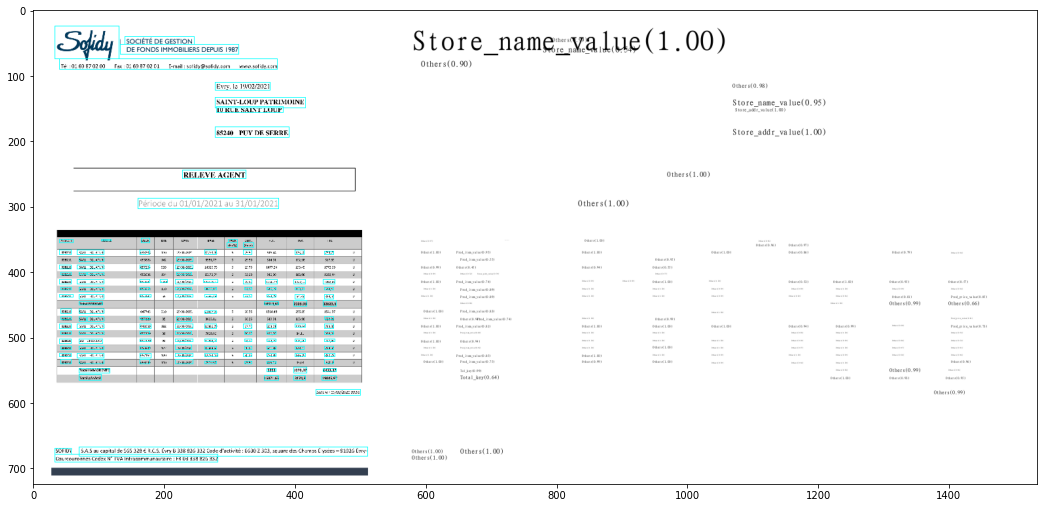

In [3]:
# Visualize the results
import matplotlib.pyplot as plt
predicted_img = mmcv.imread('demo/out004.png')
plt.figure(figsize=(18, 32))
plt.imshow(mmcv.bgr2rgb(predicted_img))
plt.show()

<IPython.core.display.Javascript object>


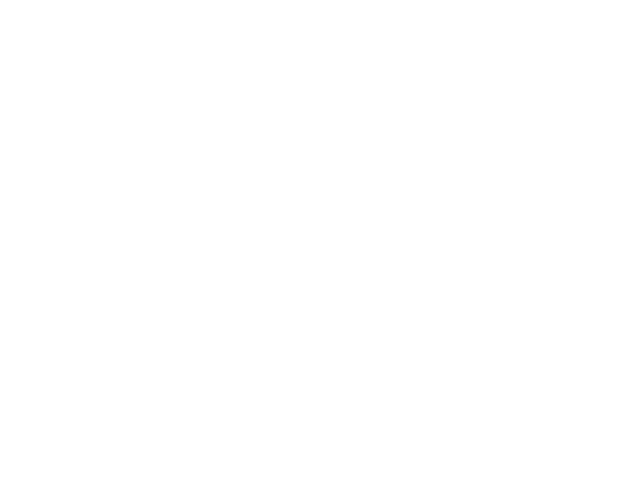

In [4]:
from sklearn.cluster import KMeans
import numpy as np
import math
import itertools

from matplotlib import pyplot as plt
%matplotlib notebook

X = np.array([[x['x']] for x in results])
ax = []
ay = []

overlapList = []
ax = []

for c in range(2, len(results)//2):
    kmeans = KMeans(n_clusters=c, random_state=42).fit(X)
    centers = [i[0] for i in kmeans.cluster_centers_]
    
    labels = kmeans.labels_
    
    overlap = 0
    
    #Find overlaping element in clusters based on xmin and xmax
    for idx, i in enumerate(centers):
        for jdx, j in enumerate(results):
            if labels[jdx] != idx:
                if i >= j['xmin'] and i <= j['xmax']:
                    overlap += 1
        
    overlapList.append(overlap)
    ax.append(c)


    
    
    
ax = np.array(ax)
ay = np.array(overlapList)

plt.plot(ax, ay)

# TODO find a WAY to IMPROVE the detection of the point which indeed is the number of cluster to play with

In [5]:
ayy = [[abs(ay[idx+1]-ay[idx])] for idx in range(len(ay) - 1)]
derivativeKmeans = KMeans(n_clusters=2, random_state=42).fit(ayy)
derivativeLabels = derivativeKmeans.labels_
print(ayy)
print(derivativeLabels)
start = derivativeLabels[0]
count = 0
xClusters = 0
for idx, i in enumerate(derivativeLabels):
    if i != start:
        count += 1
    else:
        count = 0
        
    if count == 2:
        xClusters = idx
        break
        
xClusters

[[0], [0], [0], [3], [0], [0], [2], [16], [37], [0], [22], [12], [18], [13], [38], [15], [37], [14], [21], [17], [22], [13], [15], [11], [15], [39], [21], [44], [13], [45], [10], [30], [23], [16], [8], [21], [23], [34], [49], [16], [21], [0], [28], [52], [2], [14], [54], [4], [21], [19], [23], [13], [1], [21], [4], [22], [13], [38], [21], [15], [13], [38], [16], [16], [0], [27], [0], [57], [6], [19], [36], [53], [1]]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0
 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0]


38

<IPython.core.display.Javascript object>


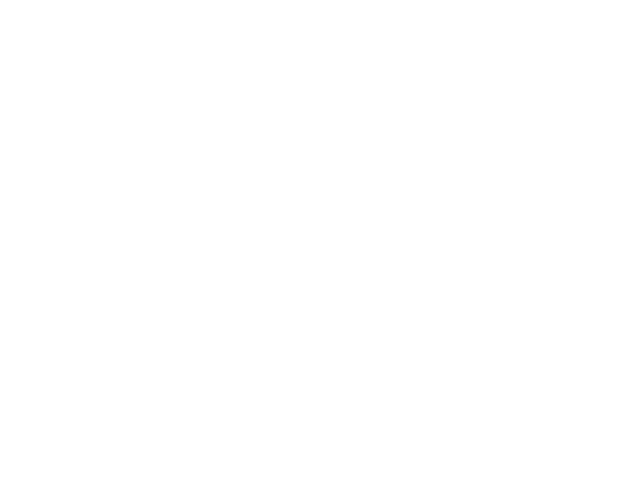

In [6]:
%matplotlib notebook

from sklearn.cluster import KMeans
import numpy as np
import math
import itertools

from matplotlib import pyplot as plt
%matplotlib notebook

X = np.array([[y['y']] for y in results])
ax = []
ay = []

overlapList = []
ax = []

for c in range(2, len(results)//2):
    kmeans = KMeans(n_clusters=c, random_state=42).fit(X)
    centers = [i[0] for i in kmeans.cluster_centers_]
    
    labels = kmeans.labels_
    
    overlap = 0
    
    #Find overlaping element in clusters based on ymin and ymax
    for idx, i in enumerate(centers):
        for jdx, j in enumerate(results):
            if labels[jdx] != idx:
                if i >= j['ymin'] and i <= j['ymax']:
                    overlap += 1
        
    overlapList.append(overlap)
    ax.append(c)
    
    
ax = np.array(ax)
ay = np.array(overlapList)

plt.plot(ax, ay)

# TODO find a WAY to IMPROVE the detection of the point which indeed is the number of cluster to play with

In [7]:
ayy = [[abs(ay[idx+1]-ay[idx])] for idx in range(len(ay) - 1)]
derivativeKmeans = KMeans(n_clusters=2, random_state=42).fit(ayy)
derivativeLabels = derivativeKmeans.labels_
start = derivativeLabels[0]
count = 0
yClusters = 0
for idx, i in enumerate(derivativeLabels):
    if i != start:
        count += 1
    else:
        count = 0
        
    if count == 2:
        yClusters = idx
        break
        
yClusters
    


49

In [8]:
yValue = 48
X = np.array([[y['y']] for y in results])

kmeans = KMeans(n_clusters=yValue, random_state=42).fit(X)
centers = [i[0] for i in kmeans.cluster_centers_]

newOrder = [{'class':idx, 'coordinate':i} for idx, i in enumerate(centers)]
newOrder.sort(key=lambda x:x['coordinate'])
yClassMapping = {i['class']: idx for idx, i in enumerate(newOrder)}

for idx, i in enumerate(kmeans.labels_):
    results[idx]['yClass'] = i

In [9]:
xValue = 8
X = np.array([[x['x']] for x in results])

kmeans = KMeans(n_clusters=xValue, random_state=42).fit(X)
centers = [i[0] for i in kmeans.cluster_centers_]

newOrder = [{'class':idx, 'coordinate':i} for idx, i in enumerate(centers)]
newOrder.sort(key=lambda x:x['coordinate'])
xClassMapping = {i['class']: idx for idx, i in enumerate(newOrder)}

labels = kmeans.labels_

for idx, i in enumerate(kmeans.labels_):
    results[idx]['xClass'] = i

In [10]:
array = [[-1 for _ in range(8)] for _ in range(48)]
for idx, i in enumerate(results):
    array[yClassMapping[i['yClass']]][xClassMapping[i['xClass']]] = idx 
    
    
for i in array:
    print(i)

[0, -1, -1, -1, -1, -1, -1, -1]
[-1, 1, -1, -1, -1, -1, -1, -1]
[2, 3, 4, 5, 6, 7, 8, 9]
[10, -1, -1, 12, 13, 14, -1, 16]
[-1, -1, 11, -1, -1, -1, 15, -1]
[-1, -1, 17, -1, -1, -1, 18, -1]
[-1, -1, -1, -1, -1, -1, 19, -1]
[20, -1, -1, -1, -1, -1, -1, -1]
[21, 22, 23, 24, 25, 26, 27, 28]
[-1, -1, -1, -1, 29, -1, -1, -1]
[-1, -1, -1, -1, 30, -1, -1, -1]
[31, 32, 33, 34, 35, 36, -1, 37]
[-1, -1, -1, -1, 38, -1, -1, -1]
[-1, -1, -1, -1, 39, -1, -1, -1]
[40, 41, 42, 43, 44, 45, 46, 47]
[-1, -1, -1, -1, 49, -1, -1, -1]
[50, 51, 52, 53, 54, 55, 56, -1]
[-1, -1, -1, -1, 57, -1, -1, -1]
[-1, -1, -1, -1, 58, -1, -1, -1]
[59, 60, 61, 62, 63, 64, 65, 66]
[-1, -1, -1, -1, 67, -1, -1, -1]
[-1, -1, -1, -1, 68, -1, -1, -1]
[70, -1, -1, -1, -1, -1, 69, 71]
[72, -1, -1, -1, -1, -1, -1, -1]
[73, 74, 75, 76, 77, 78, -1, 79]
[-1, -1, -1, -1, 80, -1, -1, -1]
[-1, -1, -1, -1, 81, -1, -1, -1]
[82, 83, 84, 85, 86, 87, -1, 88]
[-1, 89, -1, -1, 90, -1, -1, -1]
[-1, -1, -1, -1, 91, -1, -1, -1]
[92, 93, 94, 95, 96,

In [11]:
lineFactor = 0.8

def findNextLine(start, arr):
    width = len(arr[0])
    widthTrigger = round(width * lineFactor)
    firstLine = 0
    for i in range(start, len(arr)):
        a = 0
        for j in arr[i]:
            if j != -1:
                a += 1
        if a >= widthTrigger:
            return i
    return -1

firstLine = findNextLine(0, array)

In [12]:
index = firstLine
toMerge = []

while index < len(array):
    nextLine = findNextLine(index, array)
    if nextLine == -1:
        break
    elif nextLine != index:
        toMerge.append((index - 1, nextLine - 1))
        index = nextLine
    else:
        index += 1
        
print(toMerge)    

[(2, 7), (8, 10), (11, 13), (14, 15), (16, 18), (19, 23), (24, 26), (27, 29), (30, 32), (33, 37), (38, 40), (41, 43)]


In [13]:
merged = []

def fusion(rv, line):
    for idx, i in enumerate(rv):
        if line[idx] != -1:
            rv[idx].append(line[idx])
    return rv

for m in toMerge:
    t = []
    for idx in range(m[0], m[1]):
        if idx == m[0]:
            t = [[a] for a in array[idx]]
        else:
            fusion(t, array[idx])
    merged.append(t)
    
for i in merged:
    print(i)

[[2, 10], [3], [4, 11, 17], [5, 12], [6, 13], [7, 14], [8, 15, 18, 19], [9, 16]]
[[21], [22], [23], [24], [25, 29], [26], [27], [28]]
[[31], [32], [33], [34], [35, 38], [36], [-1], [37]]
[[40], [41], [42], [43], [44], [45], [46], [47]]
[[50], [51], [52], [53], [54, 57], [55], [56], [-1]]
[[59, 70], [60], [61], [62], [63, 67, 68], [64], [65, 69], [66, 71]]
[[73], [74], [75], [76], [77, 80], [78], [-1], [79]]
[[82], [83, 89], [84], [85], [86, 90], [87], [-1], [88]]
[[92], [93, 100], [94], [95], [96, 101], [97], [98], [99]]
[[103, 114], [104, 111], [105], [106], [107, 112, 113], [108], [109, 115], [110, 116]]
[[124], [118, 128], [119], [120], [121, 127], [122], [125], [126]]
[[130], [131, 138], [132], [133], [134, 139], [135], [136], [137, 123]]


In [14]:
import pandas as pd
from IPython.display import display, HTML

array = [['' for _ in range(8)] for _ in range(12)] 
for idx, i in enumerate(merged):
    for jdx, j in enumerate(i):
        text = ' '.join([results[k]['text'].replace('\n', '') for k in j])
        array[idx][jdx] = text

pdResult = pd.DataFrame(array)

display(HTML(pdResult.to_html()))

pdResult.to_csv('test1.csv')

,0,1,2,3,4,5,6,7
0,N° convention — Contrat,Nom contractant,Date début echeance/ operation,Date Fin échéance,Libellé commission,Base commission,Montant de reprise dé Commission (Annulation de,Montant de Commission
1,53023457,‘COURTIN Cyril,01/01/2021,31/03/2021,COMM. SUR FRAIS DE,"70 894,20","0,00","201,10"
2,53023457,‘COURTIN Cyril,01/07/2019,30/09/2019,COMM. SUR FRAIS DE,"14972,00",:,"0,00"
3,53023457,COURTIN Cyril,01/07/2019,30/09/2019,COMM. SUR,"14 972,00",0.00,"24,87"
4,53023457,COURTIN Cyril,01/10/2019,31/12/2019,COMM. SUR FRAIS DE,15 479.50,9.66,:
5,53023457 Sous Total 5302 - HIMALIA,COURTIN Cyril,01/10/2019,31/12/2019,COMM. SUR FRAIS DE GESTION,"15 479,50",0.00 19 02,25.67 251 64
6,83211679,ROBIN Philippe,01/01/2021,31/03/2021,COMM. SUR FRAIS DE,13 706.64,:,37.09
7,83417029,DE FONTENAY\ Emmanuel,01/01/2021,31/03/2021,COMM. SUR rRAIS VDE,"27 123,28",:,"46,95"
8,83515704,STEINBERGER Emma,01/01/2021,31/03/2021,COMM. SUR FRAIS DE,"9 606,37","0,00","28,51"
9,83515705 Sous Total 8301 - HIMALIA,STEINBERGER Mathic,01/01/2021,31/03/2021,COMM. SUR FRAIS DE GESTION,9 603.85,0.00 0.00,28.51 141.06


In [15]:
X = np.array([[x['x']] for x in results])
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans = kmeans.fit(X)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()    


In [16]:
calval = 30

kmeans = KMeans(n_clusters=calval, random_state=42).fit(X)
centers = [i[0] for i in kmeans.cluster_centers_]
    
labels = kmeans.labels_

calc = {yc:0 for yc in range(max(labels)+1)}
for i in labels:
    calc[i] += 1

toRemove = []
for key in calc:
    if calc[key] < calval:
        toRemove.append(key)

newResults = [] 
for idx, i in  enumerate(results):
    if not labels[idx] in toRemove:
        newResults.append(i)

In [17]:
X = np.array([[x['x']] for x in results])
kmeans = KMeans(n_clusters=9, random_state=42).fit(X)
xPred = kmeans.labels_
xs = [i[0] for i in kmeans.cluster_centers_]


X = np.array([[y['y']] for y in results])
kmeans = KMeans(n_clusters=10, random_state=42).fit(X)
yPred = kmeans.labels_
ys = [i[0] for i in kmeans.cluster_centers_]

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


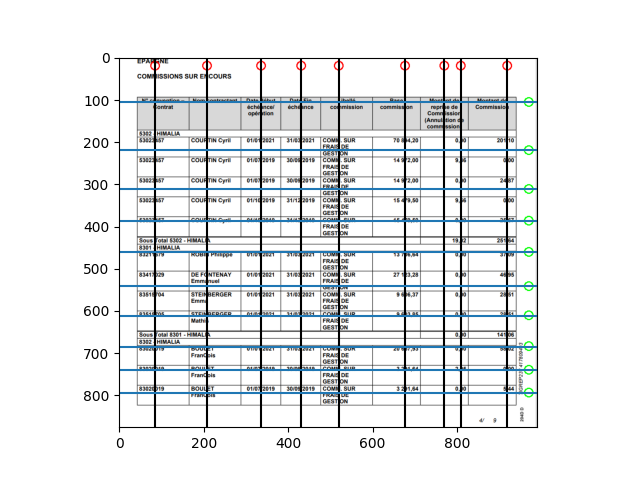

In [18]:
%matplotlib 
import cv2
from matplotlib import pyplot as plt
image = cv2.imread(img) 
for x in xs: 
    cv2.circle(image, (round(x), 20), 10, (0,0,255), 2)
     
    plt.vlines(x, 0, 1000, colors='k', linestyles='solid', label='', data=None)

x = len(image[0])-20
for y in ys: 
    cv2.circle(image, (x, round(y)), 10, (0,255,0), 2)
    
    plt.hlines(y, 0, 1600, colors=None, linestyles='solid', label='', data=None, )
#plt.savefig("test.png", format="png")    
plt.imshow(mmcv.bgr2rgb(image))
#cv2.imwrite('demo/out.png', mmcv.bgr2rgb(image))


In [19]:
#print(results)    

In [20]:
for idx, i in enumerate(results):
    print(f"({xPred[idx]}, {yPred[idx]}) => {i['text']}")

(4, 2) => EPARGNE

(0, 2) => COMMISSIONS SUR ENCOURS

(4, 2) => N° convention —

(0, 2) => Nom contractant

(5, 2) => Date début

(7, 2) => Date Fin

(2, 2) => Libellé

(6, 2) => Base

(1, 2) => Montant de

(3, 2) => Montant de

(4, 2) => Contrat

(5, 2) => echeance/

(7, 2) => échéance

(2, 2) => commission

(6, 2) => commission

(1, 2) => reprise dé

(3, 2) => Commission

(5, 2) => operation

(1, 2) => Commission

(1, 2) => (Annulation de

(4, 4) => 5302 - HIMALIA

(4, 4) => 53023457

(0, 4) => ‘COURTIN Cyril

(5, 4) => 01/01/2021

(7, 4) => 31/03/2021

(2, 4) => COMM. SUR

(6, 4) => 70 894,20

(8, 4) => 0,00

(3, 4) => 201,10

(2, 4) => FRAIS DE

(2, 4) => GESTION

(4, 4) => 53023457

(0, 4) => ‘COURTIN Cyril

(5, 4) => 01/07/2019

(7, 4) => 30/09/2019

(2, 4) => COMM. SUR

(6, 4) => 14972,00

(3, 4) => 0,00

(2, 4) => FRAIS DE

(2, 0) => GESTION

(4, 0) => 53023457

(0, 0) => COURTIN Cyril

(5, 0) => 01/07/2019

(7, 0) => 30/09/2019

(2, 0) => COMM. SUR

(6, 0) => 14 972,00

(8, 0)

In [21]:
import pandas as pd
array = [['' for _ in range(9)] for _ in range(25)] 
for idx, i in enumerate(results):
    array[yPred[idx]][xPred[idx]] = "".join(list(i['text']))

pd.DataFrame(array).to_csv("test.csv")